In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

def getTestData(n_features=100, n_informative=25, n_reduntant=25, n_samples=10000, random_state=0,
                info_sigma=0., red_sigma=.0):
    np.random.seed(random_state)
    X, y = make_classification(n_samples=n_samples, n_features=n_features - n_reduntant,
                               n_informative=n_informative, n_redundant=0, shuffle=False)
    cols = [f"I_{i}" for i in range(n_informative)]
    cols += [f"N_{i}" for i in range(n_features - n_reduntant - n_informative)]
    X = pd.DataFrame(X, columns=cols)
    y = pd.Series(y)
    for i in range(n_informative):
        col = f"I_{i}"
        X[col] = X[col] + np.random.normal(size=X.shape[0]) * info_sigma
    rdt_choices = np.random.choice(range(n_informative), size=n_reduntant)
    for i, choice in enumerate(rdt_choices):
        X[f"R_{i}"] = X[f"I_{choice}"] + np.random.normal(size=X.shape[0]) * red_sigma
    return X, y

In [2]:
X, y = getTestData(info_sigma=1, red_sigma=1)

In [7]:
X.shape

(10000, 100)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

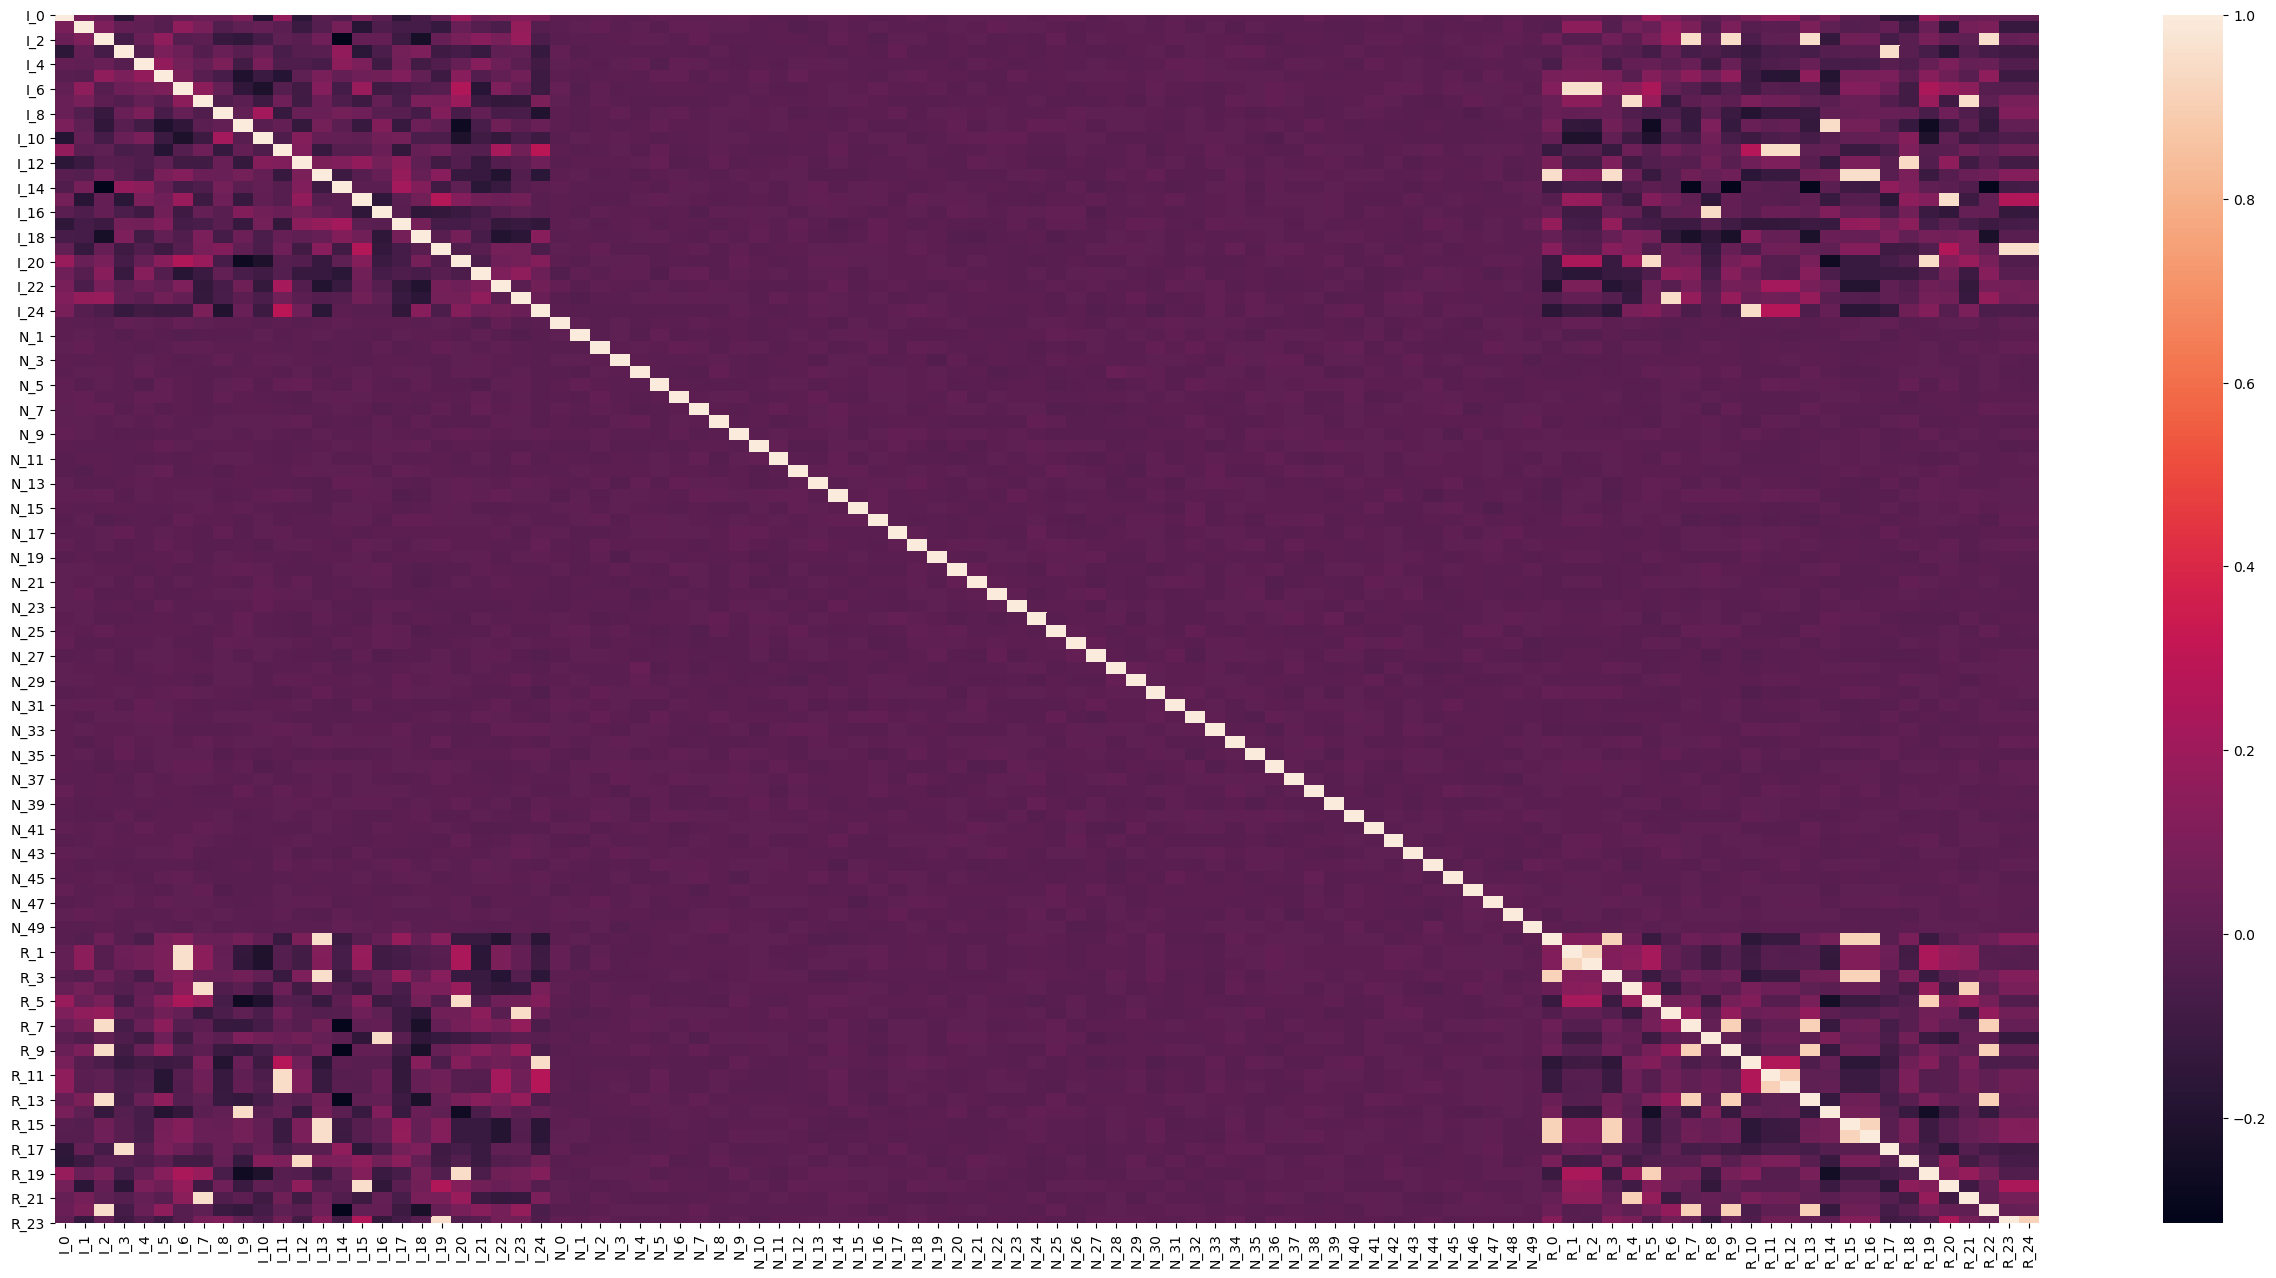

In [9]:
%matplotlib inline
import seaborn as sns


sns.heatmap(X.corr())

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from finance_ml.model_selection.utils import evaluate
from finance_ml.feature_selection import select_features

clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False)
selected_columns, curr_score = select_features(clf, X_train, y_train, mode="mdi", early_stop=False, scoring="roc")

clf.fit(X_train, y_train)
orig_score = evaluate(clf, X_test, y_test, method="roc")
clf.fit(X_train[selected_columns], y_train)
mdi_score = evaluate(clf, X_test[selected_columns], y_test, method="roc")
print(orig_score, mdi_score)

Round1: best_score=0.8816712204520598, score@90=0.8919462822070511
Round2: best_score=0.8919462822070511, score@81=0.9020647697130226
Round3: best_score=0.9020647697130226, score@72=0.9132877442743684
Round4: best_score=0.9132877442743684, score@64=0.924909247090355
Round5: best_score=0.924909247090355, score@57=0.9303004815967958
Round6: best_score=0.9303004815967958, score@51=0.9408494368519562
Round7: best_score=0.9408494368519562, score@45=0.9379394085269457
Round8: best_score=0.9408494368519562, score@40=0.9336403029776866
Round9: best_score=0.9408494368519562, score@36=0.9307174526706328
Round10: best_score=0.9408494368519562, score@32=0.9213123430154695
0.8873448744134473 0.9432681424758649


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from finance_ml.model_selection.utils import evaluate
from finance_ml.feature_selection import select_features

clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False)
selected_columns, curr_score = select_features(clf, X_train, y_train, mode="mda", early_stop=False, scoring="roc")

clf.fit(X_train, y_train)
orig_score = evaluate(clf, X_test, y_test, method="roc")
clf.fit(X_train[selected_columns], y_train)
mda_score = evaluate(clf, X_test[selected_columns], y_test, method="roc")
print(orig_score, mda_score)

Round1: best_score=0.8821342307249191, score@90=0.8897318046038543
Round2: best_score=0.8897318046038543, score@81=0.9014486785589216
Round3: best_score=0.9014486785589216, score@72=0.9147765674311614
Round4: best_score=0.9147765674311614, score@64=0.9260626126155825
Round5: best_score=0.9260626126155825, score@57=0.9330234064289071
Round6: best_score=0.9330234064289071, score@51=0.9422729125131214
Round7: best_score=0.9422729125131214, score@45=0.9457864773055501
Round8: best_score=0.9457864773055501, score@40=0.9504271572568179
Round9: best_score=0.9504271572568179, score@36=0.9507745841921607
Round10: best_score=0.9507745841921607, score@32=0.952082427734695
0.8852633569872437 0.9552438727832591


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from alpha_engine.sampler import grid_optimizer
import lightgbm as lgbm
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from finance_ml.model_selection.utils import evaluate
from finance_ml.feature_selection import select_features


def test_func(random_state, sigma, method="roc"):
    X, y = getTestData(random_state=random_state, info_sigma=sigma)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    X = X.iloc[index]
    y = y.iloc[index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = DecisionTreeClassifier(criterion="entropy", max_features=1, class_weight="balanced", min_weight_fraction_leaf=0)
    clf = BaggingClassifier(base_estimator=clf, n_estimators=100, max_features=1., max_samples=1., oob_score=False)
    
    clf.fit(X_train, y_train)
    orig_score = evaluate(clf, X_test, y_test, method=method)
    
    selected_columns, valid_mda_score = select_features(clf, X_train, y_train, mode="mda", early_stop=True,
                                                        scoring=method, num_round=20, verbose=0)
    clf.fit(X_train[selected_columns], y_train)
    mda_score = evaluate(clf, X_test[selected_columns], y_test, method=method)
    
    selected_columns, valid_mdi_score = select_features(clf, X_train, y_train, mode="mdi", early_stop=True,
                                                        scoring=method, num_round=20, verbose=0)
    clf.fit(X_train[selected_columns], y_train)
    mdi_score = evaluate(clf, X_test[selected_columns], y_test, method=method)
    result = {
        "Original": orig_score,
        "ValidMDA": valid_mda_score,
        "ValidMDI": valid_mdi_score,
        "MDA": mda_score,
        "MDI": mdi_score
    }
    return result

/Users/tomfujii/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from alpha_engine.sampler import grid_optimizer

random_states = [int(x) for x in np.arange(10)]
sigmas = [0] + list(np.logspace(-1, 1, 10))

params_conf = [
    {'name': 'random_state', 'domain': random_states},
    {'name': 'sigma', 'domain': sigmas},
]


output = grid_optimizer(test_func, params_conf, num_threads=12)

In [ ]:
output[0]

In [ ]:
output[1]

In [ ]:
output[2]

In [ ]:
output[3]

In [ ]:
output[4]

In [ ]:
from collections import defaultdict

result = defaultdict(list)
for x in output:
    result[x[1]["sigma"]].append(x[0])
    
data = list()
for x in output:
    new_x = {
        "value": x[0]["Original"],
        "type": "Original"
    }
    new_x.update(x[1])
    data.append(new_x)
    new_x = {
        "value": x[0]["MDI"],
        "type": "MDI"
    }
    new_x.update(x[1])
    data.append(new_x)
    new_x = {
        "value": x[0]["MDA"],
        "type": "MDA"
    }
    new_x.update(x[1])
    data.append(new_x)
df = pd.DataFrame(data)

In [ ]:
df

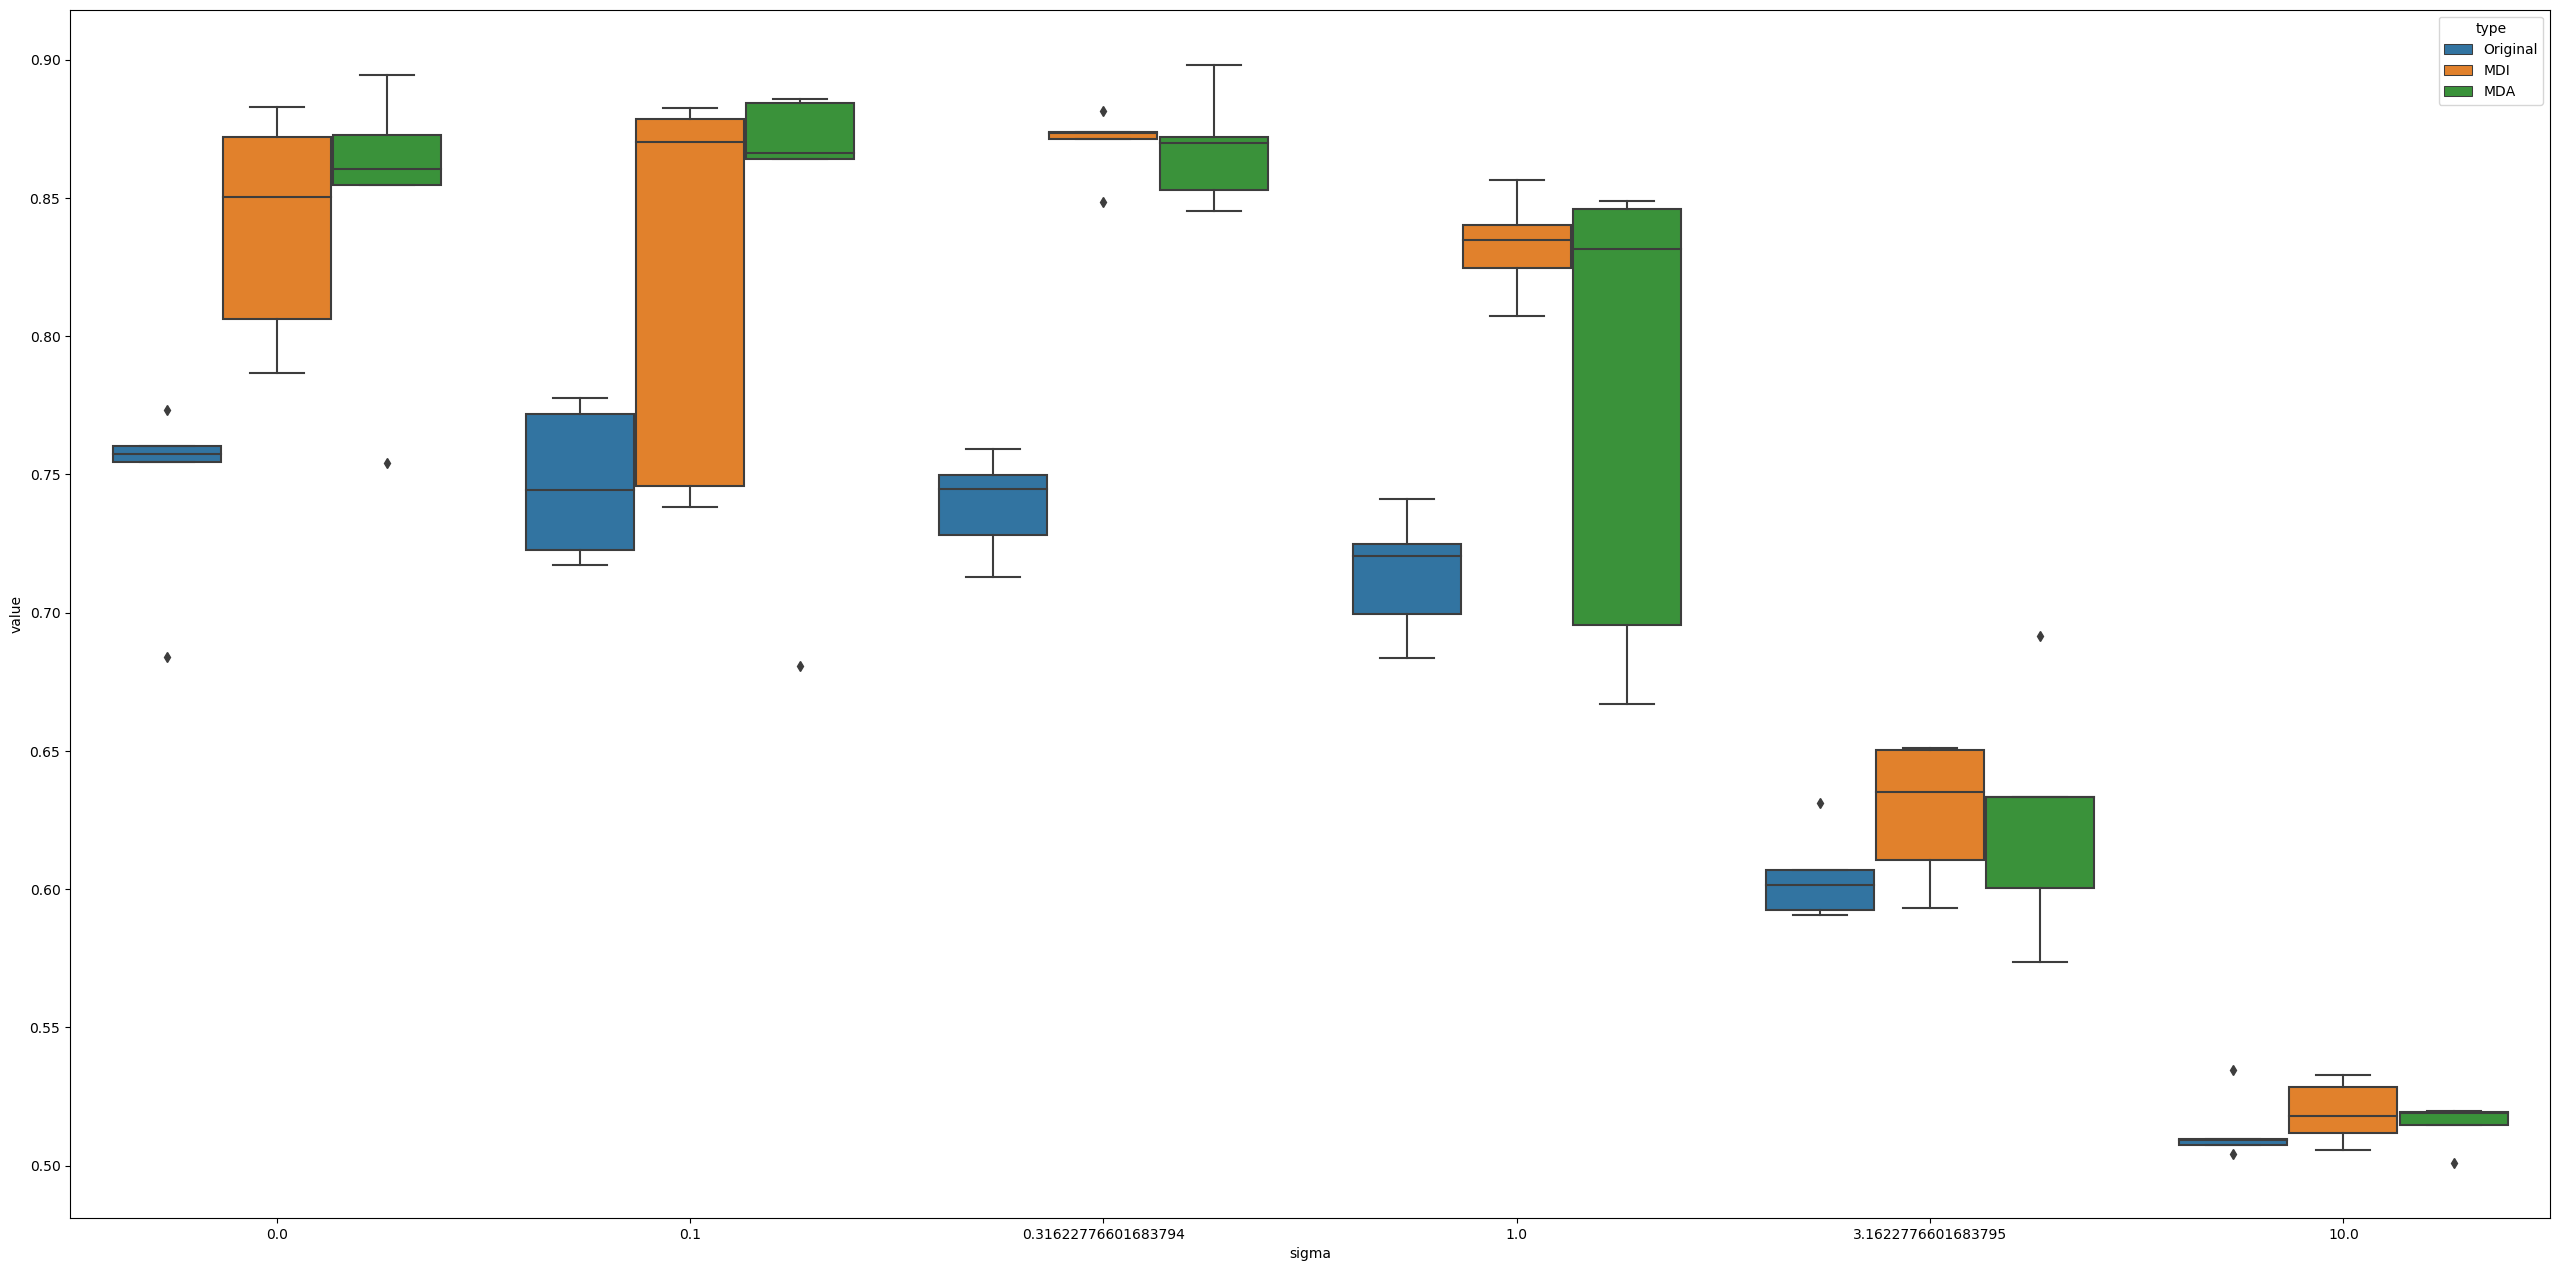

In [19]:
import seaborn as sns
%matplotlib inline

sns.boxplot(data=df, x='sigma', y='value', hue='type')

# Shap Values

In [44]:
import lightgbm as lgbm

model = lgbm.LGBMClassifier(n_estimators=100, objective="binary")
model.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [52]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X)

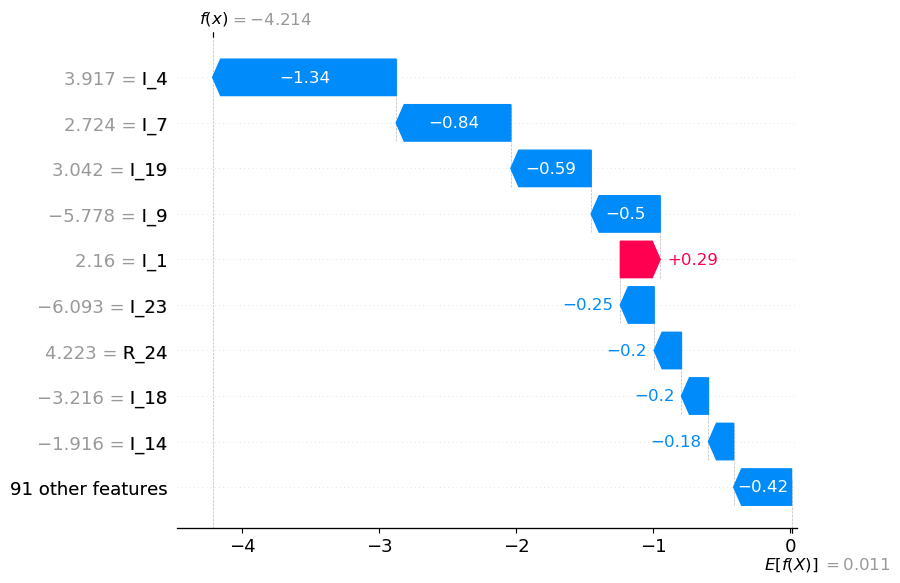

In [53]:
shap.plots.waterfall(shap_values[0, :, 1])

In [54]:
shap.initjs()
shap.plots.force(explainer.expected_value[1],
                 shap_values[0, :, 1].values,
                 feature_names=X.columns)

In [55]:
shap.initjs()
shap.plots.force(base_value=explainer.expected_value[1],
                 shap_values=shap_values[::100, :, 1].values,
                feature_names=X.columns)

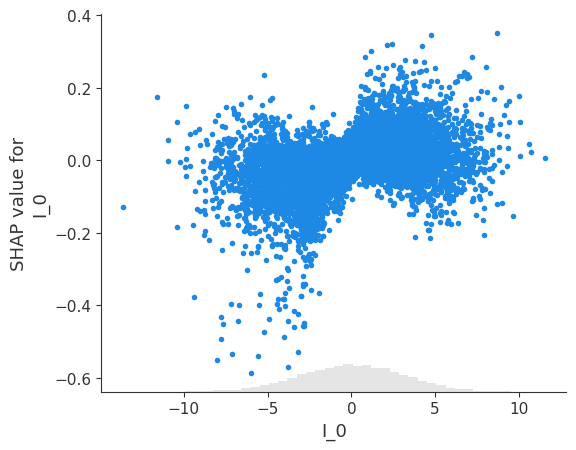

In [56]:
shap.plots.scatter(shap_values[:, "I_0", 1])

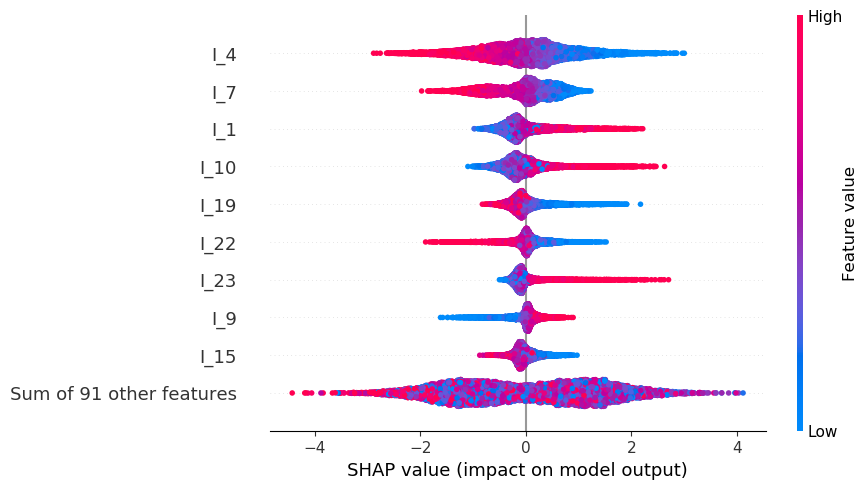

In [60]:
shap.plots.beeswarm(shap_values[:, :, 1])

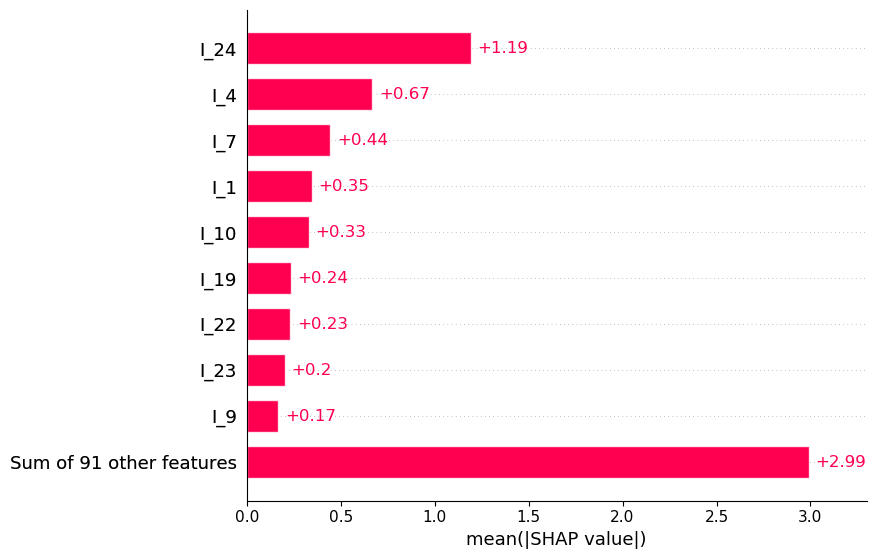

In [63]:
shap.plots.bar(shap_values[:, :, 1])